# Machine Learning Module 
The objective of the code is to be able to accuracatly predict future job vacancies in specific provinces, noc, and full time or part time. We will utilize three different machine learning modules to achieve this, linear regression, MLPRegressor, and Random Forest Regressor. 

In [1]:
# Importing main analysis libaries
import pandas as pd
import datetime as dt
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# Importing machine learning modules
from sklearn.neural_network import MLPRegressor

# Importing libaries for feature engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler  

# Import libaries for testing, splitting data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Importing config file for pulling from database
from config import config
import psycopg2

# Exporting data to database 
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

# Import ignore to stop warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Setting the seeds to be more stable states, also allowing only 30 rows of data to be displayed to save space. 
np.random.seed(0)
pd.set_option("display.max_rows", 30, "display.max_columns", None)

# IMPORT AND CLEANING

In [3]:
# Connection to database to pull CSV 
conn = psycopg2.connect(
   host = config["host"],
   port = config["port"],
   dbname =  config["dbname"],
   user = config["user"],
   password = config["password"])

print("Postgres Connected")

Postgres Connected


In [4]:
cur = conn.cursor()
cur.execute("""
ALTER TABLE machinelearning
ALTER COLUMN ref_date TYPE date using ("ref_date"::text::date)
 """)

cur.execute("""
 SELECT
*
FROM
machinelearning LIMIT 2
 """)
query_results = cur.fetchall()
print(query_results)


[(408280, datetime.date(2015, 1, 1), 'Quebec', '101', 'Total, all occupations', 'Type of work, all types', 60505.0, ''), (408283, datetime.date(2015, 1, 1), 'Quebec', '101', 'Total, all occupations', 'Full-time', 45385.0, '')]


In [5]:
df = pd.read_sql_query('SELECT * FROM "machinelearning"', con=conn)
df1 = pd.read_sql_query('SELECT * FROM "machinelearning"', con=conn)

In [6]:
conn.close()

In [7]:
df_temp=df1.copy()
df_temp.head()

,idML,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
0,408280,2015-01-01,Quebec,101,"Total, all occupations","Type of work, all types",60505.0,
1,408283,2015-01-01,Quebec,101,"Total, all occupations",Full-time,45385.0,
2,653248,2015-01-01,Saskatchewan,101,"Total, all occupations","Type of work, all types",14230.0,
3,653251,2015-01-01,Saskatchewan,101,"Total, all occupations",Full-time,10375.0,
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,


In [8]:
df_temp = df_temp.iloc[:,1:7]
df_temp.rename(columns={"ref_date" : "REF_DATE1", "geo" : "GEO1", "noc_desc" : "NOC1", "job_char" : "JOB_CHAR1"}, inplace = True)
df_temp.drop_duplicates(keep='first', inplace=True)
df_temp.head()

,REF_DATE1,GEO1,noc_code,NOC1,JOB_CHAR1,total_vacancies
0,2015-01-01,Quebec,101,"Total, all occupations","Type of work, all types",60505.0
1,2015-01-01,Quebec,101,"Total, all occupations",Full-time,45385.0
2,2015-01-01,Saskatchewan,101,"Total, all occupations","Type of work, all types",14230.0
3,2015-01-01,Saskatchewan,101,"Total, all occupations",Full-time,10375.0
4,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0


In [9]:
# Changing ref_date from datetime to string, dropping uneeded rows 2020-10, 2021-01, 2021-04 due to covid for ML, dropping uneeded rows GEO = Canada, NOC = total, all occupations, 
# renaming column titles and changing Value to int 

df['ref_date'] = df['ref_date'].apply(lambda x : x.strftime("%Y-%m"))
df.drop(["idML", "noc_code","predicted_vacancies"],axis=1, inplace=True)
df = df[~df['ref_date'].isin(['2020-10', '2021-01', '2021-04'])]
df = df[~df['geo'].isin(['Canada'])]
df = df[~df['noc_desc'].isin(["Total, all occupations"])]
df = df[~df['job_char'].isin(["Type of work, all types"])]
df.rename({"ref_date" : "REF_DATE", "geo" : "GEO", "noc_desc" : "NOC", "job_char" : "JOB_CHAR", "total_vacancies" : "VALUE"}, inplace=True, axis=1)
df["VALUE"] = df["VALUE"].astype(int)
df["NOC"] = df["NOC"].str.rstrip()
df

,REF_DATE,GEO,NOC,JOB_CHAR,VALUE
40,2015-04,Newfoundland and Labrador,"Business, finance and administration occupations",Full-time,430
42,2015-04,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,170
44,2015-04,Newfoundland and Labrador,Health occupations,Full-time,265
45,2015-04,Newfoundland and Labrador,Health occupations,Part-time,260
47,2015-04,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,130
...,...,...,...,...,...
6302,2020-01,Nunavut,"Business, finance and administration occupations",Full-time,55
6304,2020-01,Nunavut,Natural and applied sciences and related occup...,Full-time,45
6305,2020-01,Nunavut,Natural and applied sciences and related occup...,Part-time,0
6308,2020-01,Nunavut,"Trades, transport and equipment operators and ...",Full-time,85


In [10]:

df.dtypes

REF_DATE    object
GEO         object
NOC         object
JOB_CHAR    object
VALUE        int64
dtype: object

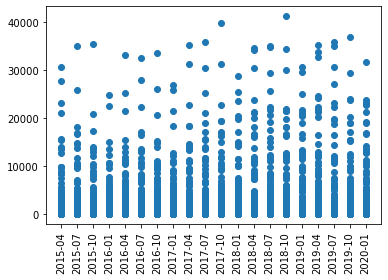

In [11]:
# Plotting the dataset just to have some sort of visual aid to assist us in understanding the data. 
plt.scatter(df.REF_DATE, df.VALUE)
plt.xticks(rotation = 90)
plt.show()

In [12]:
# Encoding Quarters by labels since orignally it is 1 4 7 10, we transform this to 1 2 3 4 Quarters, we also convert Year to INT and drop REF DATE, Formating and sorting as well
LE= LabelEncoder()
df[['YEAR', 'QUARTER']] = df['REF_DATE'].str.split('-', 1, expand=True)
df["QUARTER"]=LE.fit_transform(df["QUARTER"])
df["QUARTER"] += 1
df["YEAR"] = df["YEAR"].astype(int)
df["QUARTER"] = df["QUARTER"].astype(int)
df = df.drop(columns=["REF_DATE"])
df.sort_values(["YEAR", "QUARTER"], ascending=[True, True], inplace=True)
cols = df.columns.tolist()
cols = cols[-2:] + cols[:-2]
df = df[cols]
df

,YEAR,QUARTER,GEO,NOC,JOB_CHAR,VALUE
40,2015,2,Newfoundland and Labrador,"Business, finance and administration occupations",Full-time,430
42,2015,2,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,170
44,2015,2,Newfoundland and Labrador,Health occupations,Full-time,265
45,2015,2,Newfoundland and Labrador,Health occupations,Part-time,260
47,2015,2,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,130
...,...,...,...,...,...,...
6302,2020,1,Nunavut,"Business, finance and administration occupations",Full-time,55
6304,2020,1,Nunavut,Natural and applied sciences and related occup...,Full-time,45
6305,2020,1,Nunavut,Natural and applied sciences and related occup...,Part-time,0
6308,2020,1,Nunavut,"Trades, transport and equipment operators and ...",Full-time,85


In [13]:
# Creating a function to grab previous job vacancy and return np.nan if it does not exist, autoregression 

def prevVacancies(row):

    # There is no previous data for 2015 Quarter 2, therefor it is automatically np.nan
    if (row["YEAR"] == 2015) & (row["QUARTER"] == 2):
        return np.nan

        # If Quarter is 1 then return the previous years Quarter 4 vacancy value IF it exists, if it does not return np.nan 
    elif (row["QUARTER"] == 1): 
        if (df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"]-1)) & (df["QUARTER"] == 4) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].empty):
            return np.nan
        else:
            return df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"]-1)) & (df["QUARTER"] == 4) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].iloc[0,5]
            
    else:
        # Returns the previous Quarters value if it is not empty, if it is empty returns np.nan
        if (df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"])) & (df["QUARTER"] == (row["QUARTER"]-1)) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].empty):
            return np.nan
        else:
            return df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"])) & (df["QUARTER"] == (row["QUARTER"]-1)) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].iloc[0,5]



In [14]:
# Creating a function to join together X_test, Y_test, and Output of machine learning model into a cohesive dataframe to allow us to observe the data easier. Recoded the encoded values. 

def Prediction_Join(Input, Prediction):

    df_out = MLP_Join(Input, Prediction)

    GEO_RECODED = df_out.iloc[:,5:17].idxmax(1)
    NOC_RECODED = df_out.iloc[:,17:27].idxmax(1)
    JOB_CHAR_RECODED = df_out.iloc[:,27:29].idxmax(1)

    df_out = df_out.merge(GEO_RECODED.rename("GEO"), left_index=True, right_index=True)
    df_out = df_out.merge(NOC_RECODED.rename("NOC"), left_index=True, right_index=True)
    df_out = df_out.merge(JOB_CHAR_RECODED.rename("JOB_CHAR"), left_index=True, right_index=True)
    df_out.drop(['Alberta', 'British Columbia',
        'Manitoba', 'New Brunswick', 'Newfoundland and Labrador',
        'Northwest Territories', 'Nova Scotia', 'Nunavut', 'Ontario',
        'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon',
        'Business, finance and administration occupations',
        'Health occupations', 'Management occupations',
        'Natural and applied sciences and related occupations',
        'Natural resources, agriculture and related production occupations',
        'Occupations in art, culture, recreation and sport',
        'Occupations in education, law and social, community and government services',
        'Occupations in manufacturing and utilities',
        'Sales and service occupations',
        'Trades, transport and equipment operators and related occupations',
        'Full-time', 'Part-time'], axis=1, inplace=True)
    df_out = df_out[['YEAR', 'QUARTER', 'GEO', 'NOC', 'JOB_CHAR', 'PREVIOUS_VACANCY', 
        'PREDICTED_VACANCIES']]
    
    return df_out

In [15]:
# Joining two dataframes together and re-reanging to be a specific format
def MLP_Join(Input, Prediction):

    Pred_df = pd.DataFrame(Prediction, columns = ["PREDICTED_VACANCIES"])
    Input.reset_index(inplace=True, drop=True) 
    df_out = pd.merge(Input,Pred_df,how = 'left',left_index = True, right_index = True)
    df_out = df_out[['YEAR', 'QUARTER', 'PREVIOUS_VACANCY', 'PREDICTED_VACANCIES', 'Alberta', 'British Columbia',
        'Manitoba', 'New Brunswick', 'Newfoundland and Labrador',
        'Northwest Territories', 'Nova Scotia', 'Nunavut', 'Ontario',
        'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon',
        'Business, finance and administration occupations',
        'Health occupations', 'Management occupations',
        'Natural and applied sciences and related occupations',
        'Natural resources, agriculture and related production occupations',
        'Occupations in art, culture, recreation and sport',
        'Occupations in education, law and social, community and government services',
        'Occupations in manufacturing and utilities',
        'Sales and service occupations',
        'Trades, transport and equipment operators and related occupations',
        'Full-time', 'Part-time']]
    df_out.sort_values(["YEAR", "QUARTER"], ascending=[True, True], inplace=True)
    df_out["PREDICTED_VACANCIES"] = df_out["PREDICTED_VACANCIES"].astype(int)

    return df_out

In [16]:
# Reformating the final output 

def clean_output(output_df):

    output_df.drop(columns="PREVIOUS_VACANCY", axis = 1, inplace=True)
    output_df.loc[ output_df["QUARTER"] == 3, "QUARTER"] = 7
    output_df.loc[ output_df["QUARTER"] == 4, "QUARTER"] = 10
    output_df.loc[ output_df["QUARTER"] == 2, "QUARTER"] = 4
    output_df["REF_DATE"] = output_df["YEAR"].astype(str) + "-" + output_df["QUARTER"].astype(str)
    output_df["REF_DATE"] = pd.to_datetime(output_df["REF_DATE"])
    output_df.drop(columns=["YEAR", "QUARTER"], axis = 1, inplace=True)
    output_df = output_df[['REF_DATE', 'GEO', 'NOC', 'JOB_CHAR', 'PREDICTED_VACANCIES']]
    
    return output_df

In [17]:
# Applying function prevVacancies to dataframe for autoregression, we drop rows that do not have previous quarters i.e. 2020 Q1 data. 
df["PREVIOUS_VACANCY"] = df.apply(prevVacancies, axis=1)
df = df[df.PREVIOUS_VACANCY.notna()]
df["PREVIOUS_VACANCY"] = df["PREVIOUS_VACANCY"].astype(int)


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [18]:
df_future = df

In [19]:
# Testing if prevVacancies is working correctly
print( df.loc[(df["GEO"] == "Alberta") & (df["YEAR"] == 2020) & (df["QUARTER"] == 1) & (df["NOC"] == "Health occupations") & (df["JOB_CHAR"] == "Full-time")].iloc[0,5] )
print( df.loc[(df["GEO"] == "Alberta") & (df["YEAR"] == 2019) & (df["QUARTER"] == 4) & (df["NOC"] == "Health occupations") & (df["JOB_CHAR"] == "Full-time")].iloc[0,5] )
df.loc[(df["GEO"] == "Alberta") & (df["YEAR"] == 2020) & (df["QUARTER"] == 1) & (df["NOC"] == "Health occupations") & (df["JOB_CHAR"] == "Full-time")]

840
690


,YEAR,QUARTER,GEO,NOC,JOB_CHAR,VALUE,PREVIOUS_VACANCY
6237,2020,1,Alberta,Health occupations,Full-time,840,690


Removing rows that do not have previous Vacancy value, only a loss of 2966 -> 2456 rows 

# ENCODING 

Here we do label encoding on columns GEO, NOC, JOB_CHAR then we do OneHotEncoding on each of the columns and merge them and remove the original column. Also reset the index since we removed rows, the index numbers will not match and when we merge we will lose data going to 2002 rows. 

Creating 3 dataframes to store the label encoding order

In [20]:
a = df["GEO"].unique()
b = [ 4,  9,  6,  3, 10,  8,  2, 11,  0,  1, 12,  7,  5]

GEO_LABEL_df = pd.DataFrame(a, columns = ["GEO"])
GEO_LABEL_df.index = b
GEO_LABEL_df.sort_index(inplace=True)
GEO_LABEL_df["GEO"].values


array(['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Northwest Territories',
       'Nova Scotia', 'Nunavut', 'Ontario', 'Prince Edward Island',
       'Quebec', 'Saskatchewan', 'Yukon'], dtype=object)

In [21]:
c = df["NOC"].unique()
d = [0, 3, 1, 6, 8, 9, 7, 2, 5, 4]

NOC_LABEL_df = pd.DataFrame(c,columns = ["NOC"])
NOC_LABEL_df.index = d
NOC_LABEL_df.sort_index(inplace=True)
NOC_LABEL_df

,NOC
0,Sales and service occupations
1,Natural and applied sciences and related occup...
2,Management occupations
3,"Business, finance and administration occupations"
4,"Natural resources, agriculture and related pro..."
5,"Occupations in art, culture, recreation and sport"
6,Health occupations
7,Occupations in manufacturing and utilities
8,"Occupations in education, law and social, comm..."
9,"Trades, transport and equipment operators and ..."


In [22]:
e = df["JOB_CHAR"].unique()
f = [0, 1]

JOB_CHAR_LABEL_df = pd.DataFrame(e,columns = ["JOB_CHAR"])
JOB_CHAR_LABEL_df.index = f
JOB_CHAR_LABEL_df.sort_index(inplace=True)
JOB_CHAR_LABEL_df

,JOB_CHAR
0,Full-time
1,Part-time


In [23]:
for column in df.iloc[:,2:5]:
    
    df[column]=LE.fit_transform(df[column]) 
    print( df[column].unique())

df.reset_index(inplace = True, drop=True)

[ 4  9  6  3 10  8  2 11  0  1 12  7  5]
[8 0 3 1 6 9 7 2 5 4]
[0 1]


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
enc = OneHotEncoder(sparse=False)
encode_df = pd.DataFrame(enc.fit_transform(df.GEO.values.reshape(-1,1)))
encode_df.columns = GEO_LABEL_df["GEO"].values
encode_df

,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [25]:
encode_df2 = pd.DataFrame(enc.fit_transform(df.NOC.values.reshape(-1,1)))
encode_df2.columns = NOC_LABEL_df["NOC"].values
encode_df2

,Sales and service occupations,Natural and applied sciences and related occupations,Management occupations,"Business, finance and administration occupations","Natural resources, agriculture and related production occupations","Occupations in art, culture, recreation and sport",Health occupations,Occupations in manufacturing and utilities,"Occupations in education, law and social, community and government services","Trades, transport and equipment operators and related occupations"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2452,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2453,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2454,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
encode_df3 = pd.DataFrame(enc.fit_transform(df.JOB_CHAR.values.reshape(-1,1)))
encode_df3.columns = JOB_CHAR_LABEL_df["JOB_CHAR"].values
encode_df3

,Full-time,Part-time
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0
...,...,...
2451,1.0,0.0
2452,1.0,0.0
2453,1.0,0.0
2454,1.0,0.0


In [27]:
df = df.merge(encode_df,left_index=True,right_index=True).drop("GEO",1)
df = df.merge(encode_df2,left_index=True,right_index=True).drop("NOC",1)
df = df.merge(encode_df3,left_index=True,right_index=True).drop("JOB_CHAR",1)
df

,YEAR,QUARTER,VALUE,PREVIOUS_VACANCY,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon,Sales and service occupations,Natural and applied sciences and related occupations,Management occupations,"Business, finance and administration occupations","Natural resources, agriculture and related production occupations","Occupations in art, culture, recreation and sport",Health occupations,Occupations in manufacturing and utilities,"Occupations in education, law and social, community and government services","Trades, transport and equipment operators and related occupations",Full-time,Part-time
0,2015,3,855,955,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,2015,3,330,430,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2015,3,225,170,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2015,3,315,265,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2015,3,350,260,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,2020,1,60,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2452,2020,1,65,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2453,2020,1,55,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2454,2020,1,45,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Convert all values to int 

In [28]:
for c in (df.iloc[:,2:29].columns):
    df[c] = df[c].astype(int)


# Creating Prediction Input

We want to predict 2020 Q2 -> 2025 Q3, because there is a need for previous_vacancy value, we must do it quarter by quarter, this means 5 years by 4 quarters is a for loop of size 20. Each time we predict we must create a new input for the next quarter. Because, 2020 Q1 is 131 rows of data these means we are going to add 2620 rows of data to our output. 

In [29]:
cols = df.columns.tolist()
cols = cols[2:] + cols[:2]
df = df[cols]
df

,VALUE,PREVIOUS_VACANCY,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon,Sales and service occupations,Natural and applied sciences and related occupations,Management occupations,"Business, finance and administration occupations","Natural resources, agriculture and related production occupations","Occupations in art, culture, recreation and sport",Health occupations,Occupations in manufacturing and utilities,"Occupations in education, law and social, community and government services","Trades, transport and equipment operators and related occupations",Full-time,Part-time,YEAR,QUARTER
0,855,955,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2015,3
1,330,430,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2015,3
2,225,170,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2015,3
3,315,265,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2015,3
4,350,260,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2015,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,60,35,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,2020,1
2452,65,35,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,2020,1
2453,55,45,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2020,1
2454,45,50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2020,1


In [30]:
Y = df.iloc[:,0]
Future_Y = Y
Y

0       855
1       330
2       225
3       315
4       350
       ... 
2451     60
2452     65
2453     55
2454     45
2455     85
Name: VALUE, Length: 2456, dtype: int64

In [31]:
X = df.iloc[:,1:29]
cols = X.columns.tolist()
cols = cols[-2:] + cols[:-2]
X = X[cols]
Future_X = X
X

,YEAR,QUARTER,PREVIOUS_VACANCY,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon,Sales and service occupations,Natural and applied sciences and related occupations,Management occupations,"Business, finance and administration occupations","Natural resources, agriculture and related production occupations","Occupations in art, culture, recreation and sport",Health occupations,Occupations in manufacturing and utilities,"Occupations in education, law and social, community and government services","Trades, transport and equipment operators and related occupations",Full-time,Part-time
0,2015,3,955,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,2015,3,430,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,2015,3,170,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,2015,3,265,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,2015,3,260,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,2020,1,35,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
2452,2020,1,35,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2453,2020,1,45,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2454,2020,1,50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [32]:
X.shape, Y.shape

((2456, 28), (2456,))

# MLP REGRESSOR MODEL


In [33]:
# Setting the MLP model

model_MLP = MLPRegressor(
    hidden_layer_sizes=(28,28),  activation='relu', solver='adam', alpha=0.0001, batch_size='auto',
    learning_rate='adaptive', learning_rate_init=0.001, power_t=0.5, max_iter=5000, shuffle=True,
    random_state=1, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


In [34]:
# Creating X_test for predicting 2020 Q2 
X_test = df[(df["YEAR"] == 2020) & (df["QUARTER"] == 1)]
X_test["PREVIOUS_VACANCY"] = X_test["VALUE"]
X_test.drop(columns="VALUE", axis=1, inplace=True)
X_test["QUARTER"] = 2
cols = X_test.columns.tolist()
cols = cols[-2:] + cols[:-2]
X_test = X_test[cols]

/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [35]:
Years = [2020, 2021, 2022, 2023, 2024, 2025]
Quarters = [1, 2, 3, 4]

In [36]:
# Scaling the intial input for datafrmae 

scaler = StandardScaler()
scaler.fit(X)
X_train_MLP_scaled = scaler.transform(X)
model_MLP.fit(X_train_MLP_scaled,Y)

MLPRegressor(hidden_layer_sizes=(28, 28), learning_rate='adaptive',
             max_iter=5000, random_state=1)

In [37]:
# Creating an empty dataframe to appened predictions 

temp_output = pd.DataFrame(columns =['YEAR',
 'QUARTER',
 'GEO',
 'NOC',
 'JOB_CHAR',
 'PREVIOUS_VACANCY',
 'PREDICTED_VACANCIES'])

# CASE 0 



In [38]:
# Predicting all previous data from 2015 to 2020

Y_pred = model_MLP.predict(X_train_MLP_scaled)
Case_0 = Prediction_Join(X, Y_pred)
Case_0 = clean_output(Case_0)

print(model_MLP.n_layers_)
print('Accuracy training : {:.3f}'.format(model_MLP.score(X_train_MLP_scaled, Y)))
print('Coefficient of determination Testing (R^2): %.2f'
      % r2_score(Y, Y_pred))
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y, Y_pred))
Case_0
Case_0["REF_DATE"] = Case_0["REF_DATE"].astype(str)

Case_0.to_csv(r'Resources/MLP_Test_Future_2020to2025_Output_CASE_0.csv', index = False)

4
Accuracy training : 0.983
Coefficient of determination Testing (R^2): 0.98
Mean squared error (MSE): 569846.75


# CASE 1

All inputs are scaled, we predict per loop based on a new X_test, we did not use this method as the output converged at 2022 


for i in Years:    
    for j in Quarters:

        # We skip 2020 Q1 because we don't have data for it
        if (i == 2020) & (j == 1):
            continue              

        # If not 2020 Q2 make a new X_test, we do not include 2020 Q2 since X_test is made outside the loop and requires different formating rules     
        elif not ((i == 2020) & (j == 2)):
            # Make new X_test from Y_pred_MLP and old X_test
            temp = MLP_Join(X_test, Y_pred_MLP)
            temp["PREVIOUS_VACANCY"] = temp["PREDICTED_VACANCIES"]
            temp.drop(columns="PREDICTED_VACANCIES", axis = 1, inplace=True) 
            temp["QUARTER"] = j
            temp["YEAR"] = i
            X_test = temp
                                        
        # Scale X_test    

        scaler.fit(X_test)
        X_test_scaled = scaler.transform(X_test1)
       
    
        # Predict
        Y_pred_MLP = model_MLP.predict(X_test_scaled)

        # Append to dataframe for output
        temp = Prediction_Join(X_test, Y_pred_MLP)
        temp["QUARTER"] = j
        temp["YEAR"] = i
        temp_output = pd.concat([temp_output, temp ], ignore_index=True)        
    

temp_output = clean_output(temp_output)
temp_output.to_csv(r'Resources/MLP_Test_Future_2020to2025_Output_CASE_1.csv', index = False)

# CASE 2
All inputs scaled, we predict and fit per loop on a new X_test

In [39]:
for i in Years:    
    for j in Quarters:
        print( i , j )
        
        model_MLP = MLPRegressor(
            hidden_layer_sizes=(28,28),  activation='relu', solver='adam', alpha=0.0001, batch_size='auto',
            learning_rate='adaptive', learning_rate_init=0.001, power_t=0.5, max_iter=5000, shuffle=True,
            random_state=1, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
            early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

        # We skip 2020 Q1 because we don't have data for it
        if (i == 2020) and (j == 1):
            continue              

        # If not 2020 Q2 make a new X_test, we do not include 2020 Q2 since X_test is made outside the loop and requires different formating rules     
        elif not ((i == 2020) and (j == 2)):
            # Make new X_test from Y_pred_MLP and old X_test
            temp = MLP_Join(X_test, Y_pred_MLP)
            temp["PREVIOUS_VACANCY"] = temp["PREDICTED_VACANCIES"]
            temp.drop(columns="PREDICTED_VACANCIES", axis = 1, inplace=True) 
            temp["QUARTER"] = j
            temp["YEAR"] = i
            X_test = temp
                                              
       
        # Scale X_test
        scaler = StandardScaler()
        scaler.fit(Future_X)
        Future_X_scaled = scaler.transform(Future_X)
        X_test_scaled = scaler.transform(X_test)

        # Fit
        model_MLP.fit(Future_X_scaled, Future_Y)    
        
        # Predict
        Y_pred_MLP = model_MLP.predict(X_test_scaled)
        Y_pred_df = pd.DataFrame(Y_pred_MLP)
        Future_Y = pd.concat([Future_Y, Y_pred_df], ignore_index=True)
        Future_X = pd.concat([Future_X, X_test], ignore_index=True)

        # Append to dataframe for output
        temp = Prediction_Join(X_test, Y_pred_MLP)
        temp["QUARTER"] = j
        temp["YEAR"] = i
        temp_output = pd.concat([temp_output, temp ], ignore_index=True)        
    

print(temp_output["QUARTER"].unique())
temp_output = clean_output(temp_output)
temp_output["REF_DATE"] = temp_output["REF_DATE"].astype(str)

temp_output.to_csv(r'Resources/MLP_Test_Future_2020to2025_Output_CASE_2.csv', index = False)

2020 1
2020 2
2020 3


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2020 4


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2021 1


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2021 2


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2021 3
2021 4


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2022 1


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2022 2


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2022 3


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2022 4


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2023 1


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2023 2


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2023 3


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2023 4


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2024 1


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2024 2


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2024 3


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2024 4


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2025 1


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2025 2


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2025 3


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2025 4


/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2 3 4 1]


In [44]:
Case_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2456 entries, 0 to 2455
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   REF_DATE             2456 non-null   object
 1   GEO                  2456 non-null   object
 2   NOC                  2456 non-null   object
 3   JOB_CHAR             2456 non-null   object
 4   PREDICTED_VACANCIES  2456 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 179.7+ KB


In [45]:
temp_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5469 entries, 0 to 5468
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   REF_DATE             5469 non-null   object
 1   GEO                  5469 non-null   object
 2   NOC                  5469 non-null   object
 3   JOB_CHAR             5469 non-null   object
 4   PREDICTED_VACANCIES  5469 non-null   object
dtypes: object(5)
memory usage: 213.8+ KB


In [46]:
temp_output = pd.concat([Case_0, temp_output], ignore_index=True)

In [47]:
temp_output

,REF_DATE,GEO,NOC,JOB_CHAR,PREDICTED_VACANCIES
0,2015-07-01,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,939
1,2015-07-01,Newfoundland and Labrador,Sales and service occupations,Full-time,237
2,2015-07-01,Newfoundland and Labrador,"Business, finance and administration occupations",Full-time,224
3,2015-07-01,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,161
4,2015-07-01,Newfoundland and Labrador,Natural and applied sciences and related occup...,Part-time,358
...,...,...,...,...,...
7920,2025-10-01,Yukon,"Trades, transport and equipment operators and ...",Full-time,559
7921,2025-10-01,Nunavut,Management occupations,Full-time,750
7922,2025-10-01,Nunavut,Sales and service occupations,Full-time,526
7923,2025-10-01,Nunavut,"Business, finance and administration occupations",Full-time,-21


In [48]:
# add actual total vacancies to temp_outputs
temp_output1=temp_output.copy()

temp_output1[['Year','Quarter','Date']] = temp_output1['REF_DATE'].str.split("-",expand=True)                  
temp_output1['Quarter'] = temp_output1['Quarter'].replace(['01','04','07','10'],['1','2','3','4'])
temp_output1 =temp_output1.drop(columns=['Date'])

temp_output1["composed_id"]=temp_output1["Year"] +temp_output1["Quarter"]+ temp_output1["GEO"]+ temp_output1["NOC"]+ temp_output1["JOB_CHAR"]
temp_output1

,REF_DATE,GEO,NOC,JOB_CHAR,PREDICTED_VACANCIES,Year,Quarter,composed_id
0,2015-07-01,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,939,2015,3,20153Newfoundland and LabradorOccupations in e...
1,2015-07-01,Newfoundland and Labrador,Sales and service occupations,Full-time,237,2015,3,20153Newfoundland and LabradorSales and servic...
2,2015-07-01,Newfoundland and Labrador,"Business, finance and administration occupations",Full-time,224,2015,3,"20153Newfoundland and LabradorBusiness, financ..."
3,2015-07-01,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,161,2015,3,20153Newfoundland and LabradorNatural and appl...
4,2015-07-01,Newfoundland and Labrador,Natural and applied sciences and related occup...,Part-time,358,2015,3,20153Newfoundland and LabradorNatural and appl...
...,...,...,...,...,...,...,...,...
7920,2025-10-01,Yukon,"Trades, transport and equipment operators and ...",Full-time,559,2025,4,"20254YukonTrades, transport and equipment oper..."
7921,2025-10-01,Nunavut,Management occupations,Full-time,750,2025,4,20254NunavutManagement occupationsFull-time
7922,2025-10-01,Nunavut,Sales and service occupations,Full-time,526,2025,4,20254NunavutSales and service occupationsFull-...
7923,2025-10-01,Nunavut,"Business, finance and administration occupations",Full-time,-21,2025,4,"20254NunavutBusiness, finance and administrati..."


In [49]:
df_temp1=df_temp.copy()

df_temp1['REF_DATE1'] = df_temp1['REF_DATE1'].apply(lambda x : x.strftime("%Y-%m"))
df_temp1[['Year1','Quarter1']] = df_temp1['REF_DATE1'].str.split('-', 1, expand=True)
df_temp1['Quarter1'] = df_temp1['Quarter1'].replace(['01','04','07','10'],['1','2','3','4'])

df_temp1["composed_id"]=df_temp1["Year1"] +df_temp1["Quarter1"]+ df_temp1["GEO1"]+ df_temp1["NOC1"]+ df_temp1["JOB_CHAR1"]
df_temp1

,REF_DATE1,GEO1,noc_code,NOC1,JOB_CHAR1,total_vacancies,Year1,Quarter1,composed_id
0,2015-01,Quebec,101,"Total, all occupations","Type of work, all types",60505.0,2015,1,"20151QuebecTotal, all occupationsType of work,..."
1,2015-01,Quebec,101,"Total, all occupations",Full-time,45385.0,2015,1,"20151QuebecTotal, all occupationsFull-time"
2,2015-01,Saskatchewan,101,"Total, all occupations","Type of work, all types",14230.0,2015,1,"20151SaskatchewanTotal, all occupationsType of..."
3,2015-01,Saskatchewan,101,"Total, all occupations",Full-time,10375.0,2015,1,"20151SaskatchewanTotal, all occupationsFull-time"
4,2015-04,Canada,101,"Total, all occupations","Type of work, all types",451925.0,2015,2,"20152CanadaTotal, all occupationsType of work,..."
...,...,...,...,...,...,...,...,...,...
7225,2021-04,Nunavut,101,"Total, all occupations",Full-time,515.0,2021,2,"20212NunavutTotal, all occupationsFull-time"
7226,2021-04,Nunavut,1,"Business, finance and administration occupations","Type of work, all types",75.0,2021,2,"20212NunavutBusiness, finance and administrati..."
7227,2021-04,Nunavut,1,"Business, finance and administration occupations",Full-time,70.0,2021,2,"20212NunavutBusiness, finance and administrati..."
7228,2021-04,Nunavut,7,"Trades, transport and equipment operators and ...","Type of work, all types",160.0,2021,2,"20212NunavutTrades, transport and equipment op..."


In [50]:
df_temp1= pd.merge(temp_output1, df_temp1, on= 'composed_id', how='left')
df_temp1.fillna('')

,REF_DATE,GEO,NOC,JOB_CHAR,PREDICTED_VACANCIES,Year,Quarter,composed_id,REF_DATE1,GEO1,noc_code,NOC1,JOB_CHAR1,total_vacancies,Year1,Quarter1
0,2015-07-01,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,939,2015,3,20153Newfoundland and LabradorOccupations in e...,2015-07,Newfoundland and Labrador,4,"Occupations in education, law and social, comm...",Full-time,260.0,2015,3
1,2015-07-01,Newfoundland and Labrador,Sales and service occupations,Full-time,237,2015,3,20153Newfoundland and LabradorSales and servic...,2015-07,Newfoundland and Labrador,6,Sales and service occupations,Full-time,855.0,2015,3
2,2015-07-01,Newfoundland and Labrador,"Business, finance and administration occupations",Full-time,224,2015,3,"20153Newfoundland and LabradorBusiness, financ...",2015-07,Newfoundland and Labrador,1,"Business, finance and administration occupations",Full-time,330.0,2015,3
3,2015-07-01,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,161,2015,3,20153Newfoundland and LabradorNatural and appl...,2015-07,Newfoundland and Labrador,2,Natural and applied sciences and related occup...,Full-time,225.0,2015,3
4,2015-07-01,Newfoundland and Labrador,Natural and applied sciences and related occup...,Part-time,358,2015,3,20153Newfoundland and LabradorNatural and appl...,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7920,2025-10-01,Yukon,"Trades, transport and equipment operators and ...",Full-time,559,2025,4,"20254YukonTrades, transport and equipment oper...",,,,,,,,
7921,2025-10-01,Nunavut,Management occupations,Full-time,750,2025,4,20254NunavutManagement occupationsFull-time,,,,,,,,
7922,2025-10-01,Nunavut,Sales and service occupations,Full-time,526,2025,4,20254NunavutSales and service occupationsFull-...,,,,,,,,
7923,2025-10-01,Nunavut,"Business, finance and administration occupations",Full-time,-21,2025,4,"20254NunavutBusiness, finance and administrati...",,,,,,,,


In [51]:
df_temp1.drop_duplicates(keep='first', ignore_index=False, inplace=True)

In [52]:
temp_output2=df_temp1[["REF_DATE", "GEO", "NOC", "JOB_CHAR", "noc_code", "PREDICTED_VACANCIES", "total_vacancies"]]
temp_output2.fillna('')

,REF_DATE,GEO,NOC,JOB_CHAR,noc_code,PREDICTED_VACANCIES,total_vacancies
0,2015-07-01,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,4,939,260.0
1,2015-07-01,Newfoundland and Labrador,Sales and service occupations,Full-time,6,237,855.0
2,2015-07-01,Newfoundland and Labrador,"Business, finance and administration occupations",Full-time,1,224,330.0
3,2015-07-01,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,2,161,225.0
4,2015-07-01,Newfoundland and Labrador,Natural and applied sciences and related occup...,Part-time,,358,
...,...,...,...,...,...,...,...
7920,2025-10-01,Yukon,"Trades, transport and equipment operators and ...",Full-time,,559,
7921,2025-10-01,Nunavut,Management occupations,Full-time,,750,
7922,2025-10-01,Nunavut,Sales and service occupations,Full-time,,526,
7923,2025-10-01,Nunavut,"Business, finance and administration occupations",Full-time,,-21,


In [53]:
temp_output2.to_csv(r'Resources/MLP_2020-2025_act_pred.csv', index=True, index_label="idMlp")

In [54]:
# Send output to database
engine = create_engine(f"postgresql://{config['user']}:{config['password']}@{config['host']}:5432/{config['dbname']}")
conn=engine.connect()
temp_output2.to_sql(name="mlpoutputcod", con=conn, index=True, index_label="idMlp", if_exists="replace")
# temp_output.to_sql(name="mlpoutputcodtest", con=conn, index=True, index_label="idMlp", if_exists="replace")
conn.close()